### Sprint5 機械学習スクラッチ SVM

分類のためのサポートベクターマシン（SVM、サポートベクトルマシン）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


SVMには学習時に分類の間違いを認めるソフトマージンSVMと、認めないハードマージンSVMがありますが、ここでは実装が単純なハードマージンSVMを扱います。


以下に雛形を用意してあります。このScratchSVMClassifierクラスにコードを書き加えていってください。



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    self.n_support_vectors_memory,
    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-3, verbose=False, ganma=1, theta_zero=0, d=1):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.n_support_vectors_memory = np.zeros(self.iter)
        self.ganma = ganma # 多項式カーネルの係数　（'linear'時は1）
        self.theta_zero = theta_zero  # 多項式カーネルの定数項 （'linear'時は0）
        self.d = d  # 多項式カーネルの次元 （'linear'時は1　） 
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        n = len(X)
        self.λ = np.random.randn(n,1)
        self.y = y.reshape(-1,1) 
        self.n_support_vectors_memory = [] # サポートベクタ数の推移を記録
        self.acc_memory = []  # valデータがある場合、学習ごとの予測スコアaccuracyを記録
        
        # イテレーション回数　self.λ　を更新する
        for i in range(self.iter):
            # ラグランジュ乗数を更新
            self.λ += self.lr * (1 - np.dot(np.dot(self.y,self.y.T) * self._kernel_function(X,X), self.λ))
            self.λ = np.where((self.λ).flatten()  < 0, 0, (self.λ).flatten()).reshape(-1,1)
            
            # サポーロベクター抽出
            self.index_support_vectors = np.where(self.λ > self.threshold)[0] # サポートベクターのインデックス(n_support_vectors,)
            self.n_support_vectors = len(self.index_support_vectors) # サポートベクターの数
            self.X_sv = X[self.index_support_vectors] # サポートベクターの特徴量　(n_support_vectors, n_features)
            self.lam_sv = self.λ[self.index_support_vectors] # サポートベクターの未定乗数  (n_support_vectors, 1)
            self.y_sv = self.y[self.index_support_vectors] # サポートベクターのラベル (n_support_vectors, 1)
            self.n_support_vectors_memory.append(self.n_support_vectors) # サポートベクターの数を記録しておく
            
            if X_val is not None:
                y_val_pred = self.predict(X_val)
                self.acc_list.append(accuracy_score(y_val, pred))
                
            if self.verbose:  # verbose；True であれば学習過程を表示
                print("{}回目：n_support_vectors：{}".format(i+1,self.n_support_vectors))
                
        
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        
        f = np.dot(self._kernel_function(X,self.X_sv) , self.lam_sv * self.y_sv)
        f = f.flatten()
        return np.where(f < 0, -1, 1)
        
    
    def _kernel_function(self,Xi,Xj):
        
        if self.kernel=="linear":
            k =  Xi @ Xj.T
        
        elif self.kernel=="poly":
            k = (self.ganma*np.dot(Xi,Xj.T)+self.theta_zero)**self.d
        
        return k

### 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 $\lambda$ を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

$$
\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})
$$

ここで $k(x_i, x_j)$ はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。

$$
k(x_i, x_j) = x_{i}^{T} x_j
$$

条件として、更新毎に $\lambda_i >= 0$を満たす必要があります。満たさない場合は $\lambda_i = 0$とします。

### 【問題2】サポートベクターの決定
計算したラグランジュ乗数 $\lambda$ が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。


閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

### 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた $f(x)$ の符号が分類結果です。

### 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [3]:
# シンプルデータセット1
import numpy as np
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]
X_train, X_test, y_train, y_test= train_test_split(X,y,random_state=10)

In [4]:
# スクラッチでの学習
Scrach_model = ScratchSVMClassifier(num_iter=1000, lr=0.001, kernel='linear', threshold=1e-5, verbose=True)
Scrach_model.fit(X_train,y_train)

1回目：n_support_vectors：178
2回目：n_support_vectors：91
3回目：n_support_vectors：68
4回目：n_support_vectors：53
5回目：n_support_vectors：48
6回目：n_support_vectors：40
7回目：n_support_vectors：31
8回目：n_support_vectors：26
9回目：n_support_vectors：26
10回目：n_support_vectors：26
11回目：n_support_vectors：26
12回目：n_support_vectors：25
13回目：n_support_vectors：23
14回目：n_support_vectors：21
15回目：n_support_vectors：20
16回目：n_support_vectors：18
17回目：n_support_vectors：18
18回目：n_support_vectors：18
19回目：n_support_vectors：15
20回目：n_support_vectors：15
21回目：n_support_vectors：15
22回目：n_support_vectors：14
23回目：n_support_vectors：14
24回目：n_support_vectors：14
25回目：n_support_vectors：14
26回目：n_support_vectors：13
27回目：n_support_vectors：13
28回目：n_support_vectors：13
29回目：n_support_vectors：13
30回目：n_support_vectors：11
31回目：n_support_vectors：11
32回目：n_support_vectors：11
33回目：n_support_vectors：11
34回目：n_support_vectors：10
35回目：n_support_vectors：10
36回目：n_support_vectors：10
37回目：n_support_vectors：10
38回目：n_support_vectors：10
39回目：n_support_vecto

460回目：n_support_vectors：8
461回目：n_support_vectors：8
462回目：n_support_vectors：8
463回目：n_support_vectors：8
464回目：n_support_vectors：8
465回目：n_support_vectors：8
466回目：n_support_vectors：8
467回目：n_support_vectors：8
468回目：n_support_vectors：8
469回目：n_support_vectors：8
470回目：n_support_vectors：8
471回目：n_support_vectors：8
472回目：n_support_vectors：8
473回目：n_support_vectors：8
474回目：n_support_vectors：8
475回目：n_support_vectors：8
476回目：n_support_vectors：8
477回目：n_support_vectors：8
478回目：n_support_vectors：8
479回目：n_support_vectors：8
480回目：n_support_vectors：8
481回目：n_support_vectors：8
482回目：n_support_vectors：8
483回目：n_support_vectors：8
484回目：n_support_vectors：8
485回目：n_support_vectors：8
486回目：n_support_vectors：8
487回目：n_support_vectors：9
488回目：n_support_vectors：9
489回目：n_support_vectors：9
490回目：n_support_vectors：9
491回目：n_support_vectors：9
492回目：n_support_vectors：9
493回目：n_support_vectors：9
494回目：n_support_vectors：9
495回目：n_support_vectors：9
496回目：n_support_vectors：9
497回目：n_support_vectors：9
498回目：n_supp

807回目：n_support_vectors：10
808回目：n_support_vectors：10
809回目：n_support_vectors：10
810回目：n_support_vectors：10
811回目：n_support_vectors：10
812回目：n_support_vectors：10
813回目：n_support_vectors：10
814回目：n_support_vectors：10
815回目：n_support_vectors：10
816回目：n_support_vectors：10
817回目：n_support_vectors：10
818回目：n_support_vectors：10
819回目：n_support_vectors：10
820回目：n_support_vectors：10
821回目：n_support_vectors：10
822回目：n_support_vectors：10
823回目：n_support_vectors：10
824回目：n_support_vectors：10
825回目：n_support_vectors：10
826回目：n_support_vectors：10
827回目：n_support_vectors：10
828回目：n_support_vectors：10
829回目：n_support_vectors：10
830回目：n_support_vectors：10
831回目：n_support_vectors：10
832回目：n_support_vectors：10
833回目：n_support_vectors：10
834回目：n_support_vectors：10
835回目：n_support_vectors：10
836回目：n_support_vectors：10
837回目：n_support_vectors：10
838回目：n_support_vectors：10
839回目：n_support_vectors：10
840回目：n_support_vectors：10
841回目：n_support_vectors：10
842回目：n_support_vectors：9
843回目：n_support_vectors：9
844

Text(0, 0.5, 'n_support_vectors')

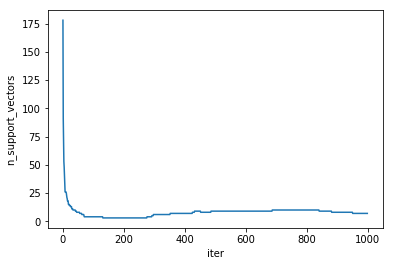

In [5]:
plt.plot(Scrach_model.n_support_vectors_memory)
plt.xlabel("iter")
plt.ylabel("n_support_vectors")

サポートベクターの数は、学習とともに現象しており、サポートベクタ〜を適切に抽出されていることが確認できた。

In [6]:
# Scrachの予測結果の評価
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

y_pred = Scrach_model.predict(X_test)

print("accuracy_score:{}".format(accuracy_score(y_test,y_pred)))
print("precision_score:{}".format(precision_score(y_test,y_pred)))
print("recall_score:{}".format(recall_score(y_test,y_pred)))
print("f1_score:{}".format(f1_score(y_test,y_pred)))
print("confusion_matrix:\n{}".format(confusion_matrix(y_test,y_pred)))

accuracy_score:1.0
precision_score:1.0
recall_score:1.0
f1_score:1.0
confusion_matrix:
[[55  0]
 [ 0 70]]


In [7]:
# Sklearnでの学習・評価結果
from sklearn.svm import SVC

svc = SVC(kernel="linear")
svc.fit(X_train,y_train)
y_pred_sklearn = svc.predict(X_test)

print("accuracy_score:{}".format(accuracy_score(y_test,y_pred_sklearn)))
print("precision_score:{}".format(precision_score(y_test,y_pred_sklearn)))
print("recall_score:{}".format(recall_score(y_test,y_pred_sklearn)))
print("f1_score:{}".format(f1_score(y_test,y_pred_sklearn)))
print("confusion_matrix:\n{}".format(confusion_matrix(y_test,y_pred_sklearn)))

accuracy_score:1.0
precision_score:1.0
recall_score:1.0
f1_score:1.0
confusion_matrix:
[[55  0]
 [ 0 70]]


**スクラッチとsklearnでの学習・予測結果は等しいことを確認できた。**

### 【問題5】決定領域の可視化
決定領域を可視化してください。


以下の例のようにサポートベクターは異なる色で示してください。

In [8]:
# 決定領域の描画関数
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    if model==Scrach_model:
        plt.scatter(X_train[Scrach_model.index_support_vectors, 0], X_train[Scrach_model.index_support_vectors, 1], s=80, color='yellow', marker='o')
    else:
        plt.scatter(X_train[svc.support_, 0], X_train[svc.support_, 1], s=80, color='yellow', marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()

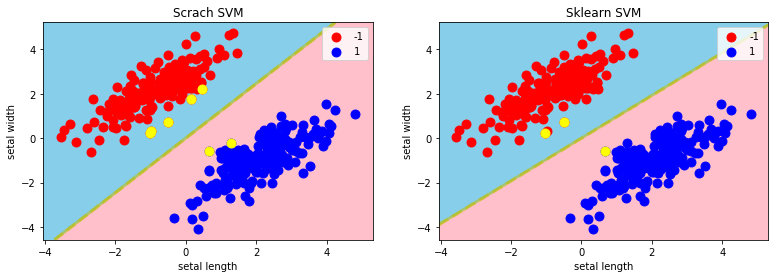

In [9]:
# スクラッチとsklearn のグラフを表示
plt.figure(figsize=(13,4))
plt.subplot(121)
decision_region(X_train, y_train, Scrach_model, step=0.01, title='Scrach SVM', xlabel='setal length', ylabel='setal width', target_names=['-1', '1'])
plt.subplot(122)
decision_region(X_train, y_train, svc, step=0.01, title='Sklearn SVM', xlabel='setal length', ylabel='setal width', target_names=['-1', '1'])

** ほぼ同様の判別ができていることが確認できた**

### 【問題6】（アドバンス課題）多項式カーネル関数の作成
最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。


「線形カーネルの式」


k
(
x
i
,
x
j
)
=
x
T
i
x
j

「多項式カーネルの式」


k
(
x
i
,
x
j
)
=
(
γ
x
T
i
x
j
+
θ
0
)
d

γ
, 
θ
0
, 
d
 はハイパーパラメータです。


線形カーネルは 
γ
=
1
, 
θ
0
=
0
, 
d
=
1
の場合の多項式カーネルと等しいと言えます。

In [10]:
Scrach_model = ScratchSVMClassifier(num_iter=1000, lr=0.0001, kernel='poly', threshold=1e-5, verbose=True, ganma=1, theta_zero=2, d=3)
Scrach_model.fit(X_train,y_train)

1回目：n_support_vectors：274
2回目：n_support_vectors：0
3回目：n_support_vectors：375
4回目：n_support_vectors：5
5回目：n_support_vectors：375
6回目：n_support_vectors：5
7回目：n_support_vectors：375
8回目：n_support_vectors：5
9回目：n_support_vectors：375
10回目：n_support_vectors：5
11回目：n_support_vectors：375
12回目：n_support_vectors：5
13回目：n_support_vectors：375
14回目：n_support_vectors：5
15回目：n_support_vectors：375
16回目：n_support_vectors：5
17回目：n_support_vectors：375
18回目：n_support_vectors：6
19回目：n_support_vectors：375
20回目：n_support_vectors：6
21回目：n_support_vectors：375
22回目：n_support_vectors：6
23回目：n_support_vectors：375
24回目：n_support_vectors：6
25回目：n_support_vectors：375
26回目：n_support_vectors：6
27回目：n_support_vectors：375
28回目：n_support_vectors：7
29回目：n_support_vectors：375
30回目：n_support_vectors：7
31回目：n_support_vectors：373
32回目：n_support_vectors：7
33回目：n_support_vectors：372
34回目：n_support_vectors：7
35回目：n_support_vectors：372
36回目：n_support_vectors：7
37回目：n_support_vectors：372
38回目：n_support_vectors：7
39回目：n_support_vector

332回目：n_support_vectors：9
333回目：n_support_vectors：9
334回目：n_support_vectors：9
335回目：n_support_vectors：9
336回目：n_support_vectors：9
337回目：n_support_vectors：9
338回目：n_support_vectors：9
339回目：n_support_vectors：9
340回目：n_support_vectors：9
341回目：n_support_vectors：9
342回目：n_support_vectors：9
343回目：n_support_vectors：9
344回目：n_support_vectors：9
345回目：n_support_vectors：9
346回目：n_support_vectors：9
347回目：n_support_vectors：9
348回目：n_support_vectors：9
349回目：n_support_vectors：9
350回目：n_support_vectors：9
351回目：n_support_vectors：9
352回目：n_support_vectors：9
353回目：n_support_vectors：9
354回目：n_support_vectors：9
355回目：n_support_vectors：9
356回目：n_support_vectors：9
357回目：n_support_vectors：9
358回目：n_support_vectors：9
359回目：n_support_vectors：9
360回目：n_support_vectors：9
361回目：n_support_vectors：9
362回目：n_support_vectors：9
363回目：n_support_vectors：9
364回目：n_support_vectors：9
365回目：n_support_vectors：9
366回目：n_support_vectors：9
367回目：n_support_vectors：9
368回目：n_support_vectors：9
369回目：n_support_vectors：9
370回目：n_supp

656回目：n_support_vectors：8
657回目：n_support_vectors：8
658回目：n_support_vectors：8
659回目：n_support_vectors：8
660回目：n_support_vectors：8
661回目：n_support_vectors：8
662回目：n_support_vectors：8
663回目：n_support_vectors：8
664回目：n_support_vectors：8
665回目：n_support_vectors：8
666回目：n_support_vectors：8
667回目：n_support_vectors：8
668回目：n_support_vectors：8
669回目：n_support_vectors：8
670回目：n_support_vectors：8
671回目：n_support_vectors：8
672回目：n_support_vectors：8
673回目：n_support_vectors：8
674回目：n_support_vectors：8
675回目：n_support_vectors：8
676回目：n_support_vectors：8
677回目：n_support_vectors：8
678回目：n_support_vectors：8
679回目：n_support_vectors：8
680回目：n_support_vectors：8
681回目：n_support_vectors：8
682回目：n_support_vectors：8
683回目：n_support_vectors：8
684回目：n_support_vectors：8
685回目：n_support_vectors：8
686回目：n_support_vectors：8
687回目：n_support_vectors：8
688回目：n_support_vectors：8
689回目：n_support_vectors：8
690回目：n_support_vectors：8
691回目：n_support_vectors：8
692回目：n_support_vectors：8
693回目：n_support_vectors：8
694回目：n_supp

985回目：n_support_vectors：7
986回目：n_support_vectors：7
987回目：n_support_vectors：7
988回目：n_support_vectors：7
989回目：n_support_vectors：7
990回目：n_support_vectors：7
991回目：n_support_vectors：7
992回目：n_support_vectors：7
993回目：n_support_vectors：7
994回目：n_support_vectors：7
995回目：n_support_vectors：7
996回目：n_support_vectors：7
997回目：n_support_vectors：7
998回目：n_support_vectors：7
999回目：n_support_vectors：7
1000回目：n_support_vectors：7


In [11]:
print("accuracy_score:{}".format(accuracy_score(y_test,y_pred)))
print("precision_score:{}".format(precision_score(y_test,y_pred)))
print("recall_score:{}".format(recall_score(y_test,y_pred)))
print("f1_score:{}".format(f1_score(y_test,y_pred)))
print("confusion_matrix:\n{}".format(confusion_matrix(y_test,y_pred)))

accuracy_score:1.0
precision_score:1.0
recall_score:1.0
f1_score:1.0
confusion_matrix:
[[55  0]
 [ 0 70]]


In [12]:
# Sklearnでの学習・評価結果
from sklearn.svm import SVC

svc = SVC(kernel="poly",random_state=0, C=1e5,gamma=1,degree=3)
svc.fit(X_train,y_train)
y_pred_sklearn = svc.predict(X_test)

print("accuracy_score:{}".format(accuracy_score(y_test,y_pred_sklearn)))
print("precision_score:{}".format(precision_score(y_test,y_pred_sklearn)))
print("recall_score:{}".format(recall_score(y_test,y_pred_sklearn)))
print("f1_score:{}".format(f1_score(y_test,y_pred_sklearn)))
print("confusion_matrix:\n{}".format(confusion_matrix(y_test,y_pred_sklearn)))

accuracy_score:1.0
precision_score:1.0
recall_score:1.0
f1_score:1.0
confusion_matrix:
[[55  0]
 [ 0 70]]


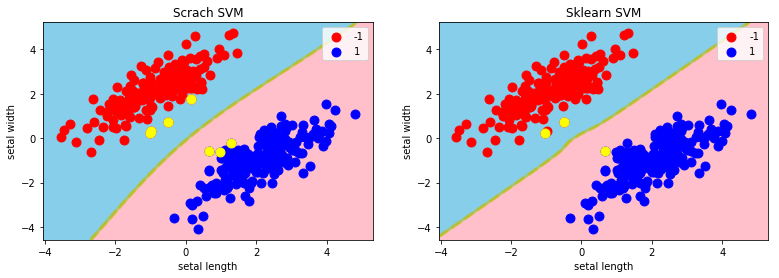

In [13]:
plt.figure(figsize=(13,4))
plt.subplot(121)
decision_region(X_train, y_train, Scrach_model, step=0.01, title='Scrach SVM', xlabel='setal length', ylabel='setal width', target_names=['-1', '1'])
plt.subplot(122)
decision_region(X_train, y_train, svc, step=0.01, title='Sklearn SVM', xlabel='setal length', ylabel='setal width', target_names=['-1', '1'])

多項式カーネル（”poly”）では、直線出なく、曲線での境界を引くことが可能となっている。今回のデータはきれいにラベルが分かれているので問題ないが、例えば、直線ではきれいに分けることができない場合に有効である。その際は、カーネル係数のgammaや次元dのパラーメータを適切に選択する。
また、sklearnではデフォルトでガウスカーネル（”rbf”）が設定されている。これはさらに境界を柔軟に対応できる（ガウスカーネルではカーネル係数gammaがパラメータとしてあり、gammaが小さいと線形カーネル、大きくするとより柔軟に曲線となる。